<img src="https://lies.mat.uc.cl/wp-content/uploads/2017/09/logo-uc-lineal-azul.png" width="300px" alt="puc logo">

<hr>
<h2 align="center"> Proyecto: Sleepy Bayesian </h2>
<h3 align="center"> Curso: Tópicos Avanzados en Inteligencia de Máquina </h3>
<h3 align="center"> Estudiantes: Fernanda Weiss (18406890) - Ignacio Espinoza (18406882)</h3>
<hr>

### Objetivos:
- Para la segunda etapa
(Avances), usted deberá presentar al menos listo el pre-processamiento necesario de los datos, junto con
la implementación inicial del modelo y las primeras pruebas experimentales

# 1) Pre-procesamiento de datos

A continuación se realizará el pre-procesamiento de los datos. Primero se cargan las librerias necesarias para toda la experimentación.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano.tensor as tt
import pymc3 as pm

#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from IPython.core.pylabtools import figsize

#sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


Se cargan los archivos desde el dataset **sleep_wake**.

In [2]:
data = pd.read_csv("sleep_wake.csv")
print("-- Information of the data --")
print(data.info())
data.head()

-- Information of the data --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
Date     64 non-null object
Sleep    64 non-null int64
Wake     64 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.6+ KB
None


,Date,Sleep,Wake
0,12/1/2017,16,1
1,12/2/2017,19,-10
2,12/3/2017,-45,0
3,12/4/2017,8,1
4,12/5/2017,-23,-16


El dataset cuenta con 64 entradas donde cada una de estas posee tres atributos: **Date**, **Sleep** y **Wake**. **Date** indica la fecha a la que corresponde la medida, **Sleep** es una diferencia (en minutos) de la hora en que se durmió ese día respecto a la hora habitual de dormir (10:00 pm) y **Wake** es una diferencia (en minutos) entre la hora en que la persona despertó y la hora habitual de despertar (6:00 am). El primer atributo es una variable tipo *date* y los dos siguientes son enteros positivos y negativos.

In [3]:
data.describe()

,Sleep,Wake
count,64.000000,64.000000
mean,14.453125,13.953125
std,27.108793,43.977783
min,-53.000000,-57.000000
25%,-0.250000,-3.000000
50%,15.500000,1.000000
75%,27.500000,1.000000
max,87.000000,195.000000


A pesar de que Sleep y Wake tengan una desviación estándar alta no es necesaria su normalización para el trabajo pues ambas variables se utilizan en contextos diferentes, no dependiendo una de la otra.

Para poder trabajar con la hora exacta en que una persona se duerme o despierta, se calcula la hora en que ocurrieron estos eventos sumando las columnas **Sleep** y **Wake** a las respectivas horas habituales en que dichos eventos suceden (10:00 pm y 6:00 am). Así, se crean los nuevos atributos **Sleep_hour** y **Wake_hour**.

In [4]:
# definir hora de dormir y despertar
data['Date'] = pd.to_datetime(data['Date'])
data['Sleep_hour'] = [d + pd.DateOffset(minutes=m, hours=22) for d, m in zip(data['Date'], data['Sleep'])]
data['Wake_hour'] = [d + pd.DateOffset(minutes=m, hours=6) for d, m in zip(data['Date'], data['Wake'])]
data.head()

,Date,Sleep,Wake,Sleep_hour,Wake_hour
0,2017-12-01,16,1,2017-12-01 22:16:00,2017-12-01 06:01:00
1,2017-12-02,19,-10,2017-12-02 22:19:00,2017-12-02 05:50:00
2,2017-12-03,-45,0,2017-12-03 21:15:00,2017-12-03 06:00:00
3,2017-12-04,8,1,2017-12-04 22:08:00,2017-12-04 06:01:00
4,2017-12-05,-23,-16,2017-12-05 21:37:00,2017-12-05 05:44:00


Luego de agregar estas columnas se separan los datos en dos datasets, Sleep_data y Wake_data, uno para los datos de la persona cuando se va a dormir y otro para cuando va a despertar. La función **create_data** genera, para cada dataset, un conjunto de datos temporalmente equispaciado (cada 1 minuto). Esta nueva información indicará la fecha y hora de la medición con un rango de fecha dado por los datos de entrada, y un rango de hora entregado como parámetro. Además, se incluye un atributo booleano **Sleep** que toma valor 1 cuando la medición dice que la persona está durmiendo y 0 para cuando está despierta, y un **offset** que indica la diferencia (en minutos) de las horas medias de dormir y despertar mencionadas anteriormente.

In [5]:
def create_data(data, first_date, last_date, night_bot, night_top, morning_bot, morning_top):
    # crear sleep data
    sleep_dates = pd.date_range(first_date, last_date, freq="1min")
    sleep_dates = sleep_dates[(sleep_dates.hour >= night_bot) & (sleep_dates.hour < night_top)]
    offset = list(range(-30*(night_top-night_bot),30*(night_top-night_bot)))*63
    is_sleep = []
    
    for date in sleep_dates:
        for hour in data['Sleep_hour']:
            if date.dayofyear == hour.dayofyear:
                if date < hour:
                    is_sleep.append(0) # awake
                else:
                    is_sleep.append(1) # sleeping
    sleep_data = pd.DataFrame({'Date': sleep_dates, 'Sleep': is_sleep, 'Offset': offset})
    
    # crear wake data
    wake_dates = pd.date_range(first_date, last_date, freq="1min")
    wake_dates = wake_dates[(wake_dates.hour >= morning_bot) & (wake_dates.hour < morning_top)]
    is_sleep = []

    for date in wake_dates:
        for hour in data['Wake_hour']:
            if date.dayofyear == hour.dayofyear:
                if date < hour:
                    is_sleep.append(1) # sleeping
                else:
                    is_sleep.append(0) # awake
    wake_data = pd.DataFrame({'Date': wake_dates, 'Sleep': is_sleep, 'Offset': offset})
    
    return sleep_data, wake_data

Puesto que se manejan pocos datos será difícil que los modelos a entrenar puedan predecir bien datos futuro pues no podrán generalizar bien y existirá overfitting. La solución a esto se hará un preprocesamiento de datos que permita agregar información real a cada dataset. Nuestro supuesto es que con más datos se puede obtener un mejor modelamiento de la transición entre estados.

Para tener un mayor espectro de análisis se generan dos dataset, el primero con un rango de $\pm1$ hora de diferencia (21 a 23 pm y 5 a 7 am) y el segundo con $\pm2$ horas de diferencia (20 a 24 pm y 4 a 8 am). Así el primer conjunto de datos con 15.120 datos y el segundo con 30.240 datos. Cabe recordar que dada la naturaleza del problema para un dataset la mitad de los datos se utilizan en el analisis de la transición a dormir y la otra mitad para despertar.

In [6]:
first_date = min(data['Date'])
last_date = max(data['Date'])
sleep1, wake1 = create_data(data, first_date, last_date, 21, 23, 5, 7)
sleep2, wake2 = create_data(data, first_date, last_date, 20, 24, 4, 8)

In [7]:
print("Observaciones dataset 1 - Datos de dormir: %d - Datos de despertar: %d " % (len(sleep1), len(wake1)))
print("Observaciones dataset 2 - Datos de dormir: %d - Datos de despertar: %d " % (len(sleep2), len(wake2)))

Observaciones dataset 1 - Datos de dormir: 7560 - Datos de despertar: 7560 
Observaciones dataset 2 - Datos de dormir: 15120 - Datos de despertar: 15120 


Posteriormente se exportan los datos para futuros trabajos.

In [ ]:
sleep1.to_csv("sleep1_data.csv")
wake1.to_csv("wake1_data.csv")
sleep2.to_csv("sleep2_data.csv")
wake2.to_csv("wake2_data.csv")

Una vez terminado el preprocesamiento se grafican los datos para ver cómo estos se distribuyen en el tiempo. Los siguientes gráficos mostrarán puntos en donde su intensidad en color representará la frecuencia de datos en ese instante en específico. 

A continuación se presentan los gráficos para la transición despierto-dormido.

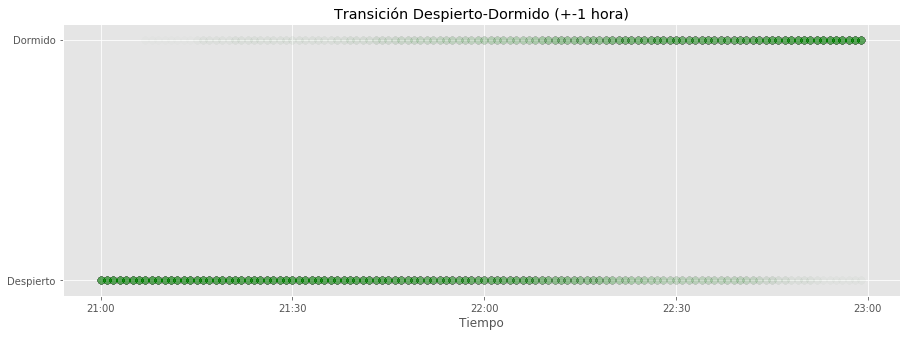

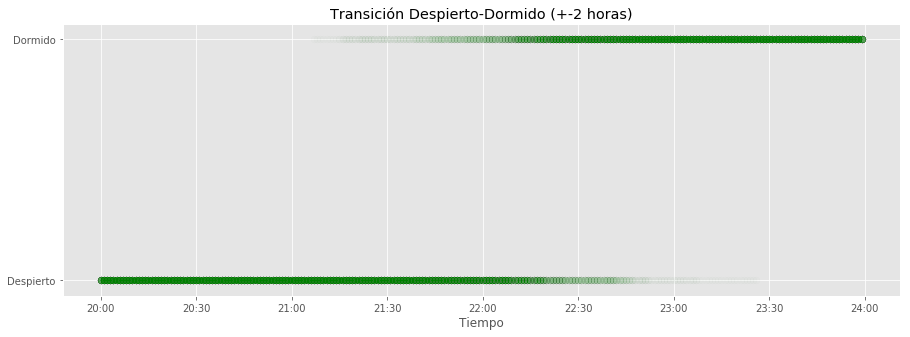

In [7]:
sleep_labels = ["20:00", "20:30", "21:00", "21:30", "22:00", "22:30", "23:00", "23:30", "24:00"]

plt.figure(figsize=(15, 5))
plt.scatter(sleep1['Offset'], sleep1['Sleep'], s=60, alpha=0.01, c='g')
plt.yticks([0, 1], ["Despierto", "Dormido"])
plt.xlabel("Tiempo")
plt.title("Transición Despierto-Dormido (+-1 hora)")
plt.xticks([-60, -30, 0, 30, 60], sleep_labels[2:]);

plt.figure(figsize=(15, 5))
plt.scatter(sleep2['Offset'], sleep2['Sleep'], s=50, alpha=0.01, c='g')
plt.yticks([0, 1], ["Despierto", "Dormido"])
plt.xlabel("Tiempo")
plt.title("Transición Despierto-Dormido (+-2 horas)")
plt.xticks([-120, -90, -60, -30, 0, 30, 60, 90, 120], sleep_labels);

Ahora, se muestran los datos de la transición dormido-despierto.

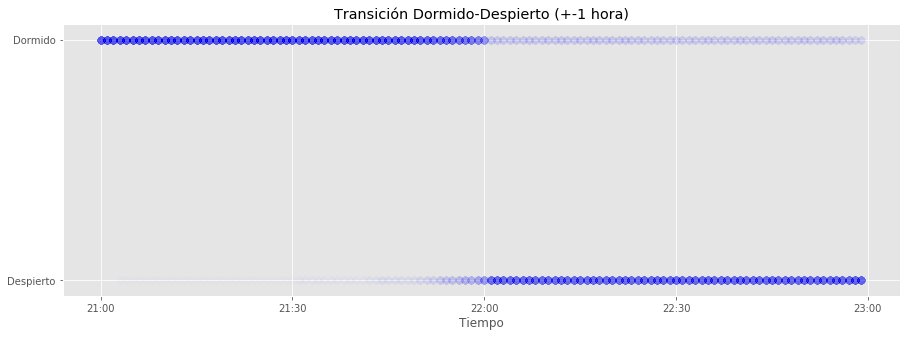

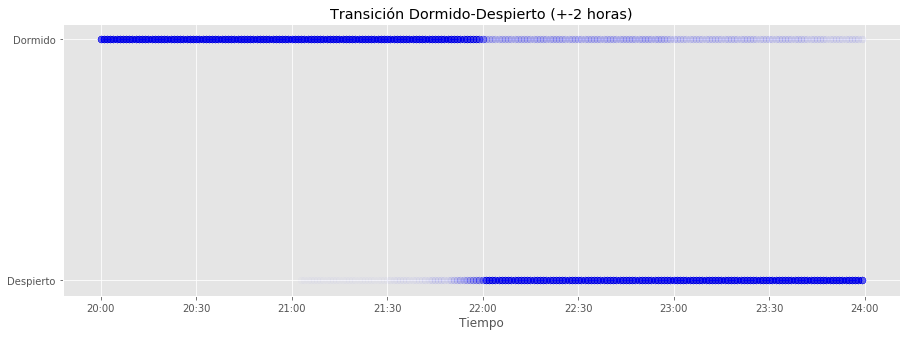

In [8]:
wake_labels = ["4:00", "4:30", "5:00", "5:30", "6:00", "6:30", "7:00", "7:30", "8:00"]

plt.figure(figsize=(15, 5))
plt.scatter(wake1['Offset'], wake1['Sleep'], s=60, alpha=0.01, c='b')
plt.yticks([1, 0], ["Dormido", "Despierto"])
plt.xlabel("Tiempo")
plt.title("Transición Dormido-Despierto (+-1 hora)")
plt.xticks([-60, -30, 0, 30, 60], sleep_labels[2:]);

plt.figure(figsize=(15, 5))
plt.scatter(wake2['Offset'], wake2['Sleep'], s=50, alpha=0.01, c='b')
plt.yticks([1, 0], ["Dormido", "Despierto"])
plt.xlabel("Tiempo")
plt.title("Transición Dormido-Despierto (+-2 horas)")
plt.xticks([-120, -90, -60, -30, 0, 30, 60, 90, 120], sleep_labels);

# 2) Función logística



\\[f(t) = \frac{1}{1+e^{-\beta t}}\\]



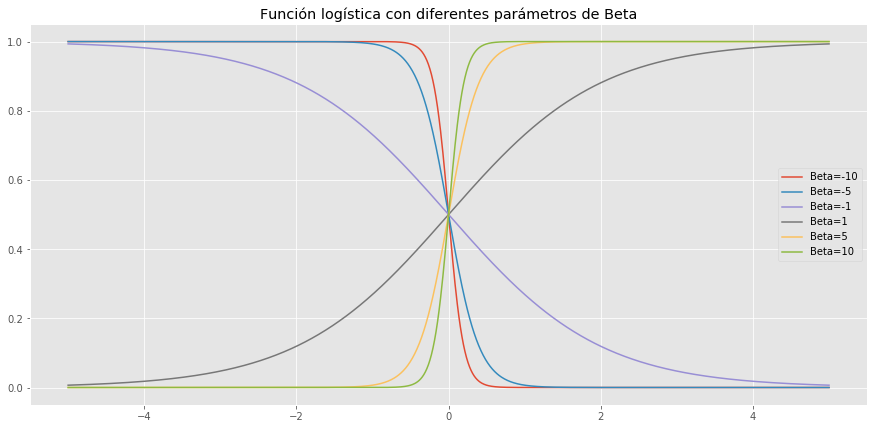

In [9]:
logistic = lambda x, beta : 1 / (1 + np.exp(-beta * x))

x = np.linspace(-5,5,1000)
beta = [-10, -5, -1, 1, 5, 10]

plt.figure(figsize=(15,7))
for b in beta:
    plt.plot(x, logistic(x, b), label="Beta="+str(b))
plt.title("Función logística con diferentes parámetros de Beta")
plt.legend();

# Regresión logística

Como necesitamos una función que modele el problema y que no necesariamente esté centrada simétricamente en cero se utilizará la ecuación de Regresión logística, donde el término $\beta_0$ permitirá que la curva pueda moverse en el eje x. Con esto $\beta_0$ cambiará la ubicación de la curva y $\beta_1$ determinará la pendiende y dirreción.

\\[f(t) = \frac{1}{1+e^{-(\beta_0+\beta_1*t)}}\\]

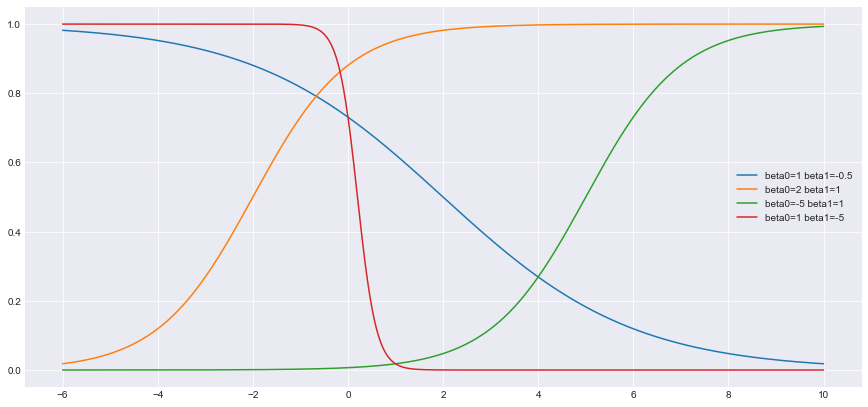

In [2]:
reg_logistic = lambda x, beta0, beta1 : 1 / (1 + np.exp(-(beta0 + beta1*x)))

x = np.linspace(-6,10,1000)
plt.figure(figsize=(15,7))
plt.plot(x, reg_logistic(x, 1, -0.5), label="beta0=1 beta1=-0.5")
plt.plot(x, reg_logistic(x, 2, 1), label="beta0=2 beta1=1")
plt.plot(x, reg_logistic(x, -5,1), label="beta0=-5 beta1=1")
plt.plot(x, reg_logistic(x, 1,-5), label="beta0=1 beta1=-5")
plt.legend();

# Modelomiento de los datos

Regresión logística bayesiana: las componentes dentro del *framework* bayesiano aosiado a la estimación de parámetros son: la distribución *prior*, la función de verosimilitud o *likelihood*, y la distribución a posterior. Estos términos se relacionan mediante la Regla de Bayes de la siguiente forma

\\[Posterior \propto Likelihood * Prior \\]

Por lo tanto la distribución a posterior contiene la información entregada por los datos, contenida en la likelihood, y la información que se tiene como conocimiento previo o proveniente de otras fuentes de información, contenida en el prior.

La función de likelihood, como se dijo anteriormente, contiene la información de los datos y proviene de una inferencia frecuentista. Dada la probabilidad de exito  la contribución del i-ésimo elemento se modela con una distribución binomial

### Por favor, ver propuesta modificada para más detalle. Luego se agregarán dichos detalles en este formato.

In [3]:
sleep1 = pd.read_csv("sleep1_data.csv")
sleep2 = pd.read_csv("sleep2_data.csv")
wake1 = pd.read_csv("wake1_data.csv")
wake2 = pd.read_csv("wake2_data.csv")

Separamos los datos en:
1. Dormir +/-1 hora
2. Dormir +/-2 hora
3. Despertar +/-1 hora
4. Despertar +/-2 hora

Se considerará obtener 5000 muestras en cada algoritmo de sampleo.

In [4]:
n_samples = 5000

sleep1_obs = sleep1["Sleep"].values
sleep1_time = sleep1["Offset"].values

sleep2_obs = sleep2["Sleep"].values
sleep2_time = sleep2["Offset"].values

wake1_obs = wake1["Sleep"].values
wake1_time = wake1["Offset"].values

wake2_obs = wake2["Sleep"].values
wake2_time = wake2["Offset"].values

## Algoritmos de Sampleo
### Metropolis-Hastings con PyMC3

In [7]:
def metropolis_hasting(obs, time, samples, start=None):
    with pm.Model() as model:
        # Parámetros beta0 y beta1
        beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)

        # Probabilidad de la función logistica
        p = pm.Deterministic('p',  1 / (1 + np.exp(-(beta0 + beta1*time)))) 

        # Parametro bernoulli que usa los datos observados
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Usando Metropolis
        step = pm.Metropolis()
        #db = pm.backends.Text('met')
        # Samplear de la posterior usando Metropolis
        trace = pm.sample(samples, step=step, njobs=1, start=start)#, trace=db);
        #gelman = pm.gelman_rubin(trace)
    return model, trace

### Slide sampling con PyMC3

In [21]:
def slice_sampling(obs, time, samples):
    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)
        p = pm.Deterministic('p', 1. / (1. + tt.exp(-(beta0 + beta1 * time))))
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Usando Slice sampling
        step = pm.Slice()

        # Samplear de la posterior usando Slice sampling
        trace = pm.sample(samples, step=step, njobs=1);
    return model, trace

### Hamiltonian Monte Carlo con PyMC3

Se agrega un pequeño epsilon en el divisor para evitar problemas con valores ceros en la diagonal de la *Mass Matrix*. Al solucionar esto se evita que algunas de las derivadas sean siempre cero. (Error: *Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.*)

In [22]:
def hamiltonian_mc(obs, time, samples):
    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0.0, sd=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, sd=0.01, testval=0.0)
        p = pm.Deterministic('p', 1. / (1. + tt.exp(-(beta0 + beta1 * time)))+1e-10)
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Usando Hamiltonian Monte Carlo
        step = pm.HamiltonianMC()

        # Samplear de la posterior usando Hamiltonian Monte Carlo
        trace = pm.sample(samples, step=step, njobs=1);
    return model, trace

In [34]:
def nuts(obs, time, samples):
    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0.0, sd=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, sd=0.01, testval=0.0)
        p = pm.Deterministic('p', 1. / (1. + tt.exp(-(beta0 + beta1 * time))))
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Usando NUTS
        step = pm.NUTS()
        # Samplear de la posterior usando NUTS
        trace = pm.sample(samples, step=step, njobs=1);
    return model, trace

### Funciones de Plots

In [23]:
# Labels para plots
sleep_labels = ['8:00','8:30','9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['4:00','4:30','5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

In [37]:
def plot_hist(beta0, beta1, samples, suptitle):
    figsize(16, 5)

    plt.subplot(121)
    plt.title(r"""Distribucion de $\beta_0$ con %d muestras""" % samples)
    plt.hist(beta0, histtype='stepfilled', color = 'darkred', bins=30, density=True);
    plt.ylabel('Densidad de probabilidad')
    
    plt.subplot(122)
    plt.title(r"""Distribucion de $\beta_1$ con %d muestras""" % samples)
    plt.hist(beta1, histtype='stepfilled', color = 'darkblue', bins=30, density=True)
    plt.ylabel('Densidad de probabilidad')
    plt.suptitle(suptitle)
    plt.show()

In [56]:
def plot_fit(time_est, sleep_est_1, sleep_est_2, sleep_est_3, sleep_est_4, time, obs, samples, title, m, labels):    
    figsize(16, 6)

    plt.plot(time_est, sleep_est_1, color = 'navy', lw=10, label="Modelo logistico MH")
    plt.plot(time_est, sleep_est_2, color = 'green', lw=10, label="Modelo logistico NUTS")
    plt.plot(time_est, sleep_est_3, color = 'red', lw=3, label="Modelo logistico HamiltonMC")
    plt.plot(time_est, sleep_est_4, color = 'yellow', lw=3, label="Modelo logistico Slice")
    plt.scatter(time, obs, edgecolor = 'slateblue', s=50, alpha=0.2, label='obs')
    plt.suptitle(title)
    plt.title('Distribución de probabilidad con %d muestras' % samples);
    plt.legend(prop={'size':18})
    plt.ylabel('Probabilidad')
    plt.xlabel('Hora ' + m);
    plt.xticks([-120,-90,-60, -30, 0, 30, 60, 90, 120], labels);

In [54]:
def plot_fit_colormap(trace, time, obs, labels, m):
    colors  =  ["#348ABD" , "#A60628", "#7A68A6"]
    cmap = clr.LinearSegmentedColormap.from_list("BMH", colors)
    figsize(14, 7)
    probs = trace['p']
    plt.scatter(time, probs.mean(axis=0), cmap = cmap, c = probs.mean(axis=0), s = 50, label="Modelo logistico");
    plt.scatter(time, obs, edgecolor = 'green', color = 'green', s=50, alpha=0.2, label='obs')
    plt.title('Probabilidad de dormir como función del tiempo')
    plt.legend(prop={'size':18})
    plt.ylabel('Probabilidad')
    plt.xlabel('Hora ' + m)
    plt.xticks([-120,-90,-60, -30, 0, 30, 60, 90, 120], labels);
    plt.show()

## Métodos de convergencia
### Métodos de convergencia gráficos

In [27]:
def graph_analysis(trace, title):
    pm.traceplot(trace, ['beta0', 'beta1'], figsize=(12,6));
    pm.autocorrplot(trace = trace, varnames = ['beta0', 'beta1'], figsize=(12,6)); #no se muestra, pero si se quieta no se ve el traceplot .-.
    pm.forestplot(trace, varnames=['beta0', 'beta1']);
    pm.autocorrplot(trace = trace, varnames = ['beta0', 'beta1'], figsize=(12,6));

### Métodos de convergencia más "formales"

In [28]:
def geweke(trace, first = 0.1, last = 0.5):
    score=pm.geweke(trace, first=first, last=last)
    
    figsize(16, 8)
    plt.suptitle('Geweke Plot Comparando el primer 10% con el ultimo 50%  de la diferenrencia en cada cadena en Z score')
    
    plt.subplot(221)
    plt.scatter(score[[*score][0]]['beta0'][:,0],score[[*score][0]]['beta0'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta0'].shape[0]/2+10)
    plt.title(r"""Primera cadena $\beta_0$""")
        
    plt.subplot(222)
    plt.scatter(score[[*score][0]]['beta1'][:,0],score[[*score][0]]['beta1'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta1'].shape[0]/2+10)
    plt.title(r"""Primera cadena $\beta_1$""")
        
    plt.subplot(223)
    plt.scatter(score[[*score][-1]]['beta0'][:,0],score[[*score][-1]]['beta0'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta0'].shape[0]/2+10)
    plt.title(r"""Segunda cadena $\beta_0$""")
        
    plt.subplot(224)
    plt.scatter(score[[*score][-1]]['beta1'][:,0],score[[*score][-1]]['beta1'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta1'].shape[0]/2+10)
    plt.title(r"""Segunda cadena $\beta_1$""")
    plt.show()

In [76]:
def gelman_rubin(trace):
    conv = pm.gelman_rubin(trace, ['beta0', 'beta1'])
    print("Convergencia de Gelman-Rubin")
    if(conv['beta0'] > 0.98 and conv['beta0'] <1.1):
        print("\t El parámetro beta0 ha convergido")
    print("\t \t beta0: ", conv['beta0'])
    if(conv['beta1'] > 0.98 and conv['beta1'] <1.1):
        print("\t El parámetro beta1 ha convergido")
    print("\t \t beta1: ", conv['beta1'])

In [30]:
def running_means(trace):
    chains = []
    for i in trace.chains:
        beta0 = trace.get_values('beta0', chains=i)
        beta1 = trace.get_values('beta1', chains=i)
        means_beta0 = []
        means_beta1 = []
        for i in range(1,len(trace)):
            means_beta0 = np.append(means_beta0, sum(beta0[:i])/i)
            means_beta1 = np.append(means_beta1, sum(beta1[:i])/i)
        chains.append([means_beta0, means_beta1])
    
    i=0
    for chain in chains:
        i+=1
        x_axis = range(len(trace)-1)
        plt.figure(figsize=(15, 5))
        plt.suptitle("Running means para la cadena numero " + str(i))
        plt.subplot(121)
        plt.plot(x_axis, chain[0])
        plt.xlabel("Iteraciones")
        plt.ylabel("beta0")

        plt.subplot(122)
        plt.plot(x_axis, chain[1])
        plt.xlabel("Iteraciones")
        plt.ylabel("beta1")
        plt.show()

## Modelos para los cuatro algoritmos de sampleo

In [8]:
sleep1_met_model, sleep1_met = metropolis_hasting(sleep1_obs, sleep1_time, n_samples)
sleep2_met_model, sleep2_met = metropolis_hasting(sleep2_obs, sleep2_time, n_samples)

wake1_met_model, wake1_met = metropolis_hasting(wake1_obs, wake1_time, n_samples)
wake2_met_model, wake2_met = metropolis_hasting(wake2_obs, wake2_time, n_samples)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1]
>Metropolis: [beta0]
100%|██████████| 5500/5500 [00:18<00:00, 299.05it/s]
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1]
>Metropolis: [beta0]
100%|██████████| 5500/5500 [00:33<00:00, 162.26it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1]
>Metropolis: [beta0]
100%|██████████| 5500/5500 [00:18<00:00, 293.05it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1]
>Metropolis: [beta0]
100%|██████████| 5500/5500 [00:34<00:00, 157.58it/s]
The number of effective samples is smaller than 10% for some parameters.


In [93]:
#sleep1_ss_model, sleep1_ss = slice_sampling(sleep1_obs, sleep1_time, n_samples)
sleep2_ss_model, sleep2_ss = slice_sampling(sleep2_obs, sleep2_time, n_samples)

#wake1_ss_model, wake1_ss = slice_sampling(wake1_obs, wake1_time, n_samples)
#wake2_ss_model, wake2_ss = slice_sampling(wake2_obs, wake2_time, n_samples)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [beta1]
>Slice: [beta0]
100%|██████████| 5500/5500 [02:00<00:00, 45.71it/s]


In [95]:
#sleep1_hmc_model, sleep1_hmc = hamiltonian_mc(sleep1_obs, sleep1_time, n_samples)
sleep2_hmc_model, sleep2_hmc = hamiltonian_mc(sleep2_obs, sleep2_time, n_samples)

#wake1_hmc_model, wake1_hmc = hamiltonian_mc(wake1_obs, wake1_time, n_samples)
#wake2_hmc_model, wake2_hmc = hamiltonian_mc(wake2_obs, wake2_time, n_samples)

Sequential sampling (2 chains in 1 job)
HamiltonianMC: [beta1, beta0]
  0%|          | 6/5500 [06:12<94:48:15, 62.12s/it]/home/nacho/anaconda3/envs/proyectopuc/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
#sleep1_nut_model, sleep1_nut = nuts(sleep1_obs, sleep1_time, n_samples)
sleep2_nut_model, sleep2_nut = nuts(sleep2_obs, sleep2_time, n_samples)

#wake1_nut_model, wake1_nut = nuts(wake1_obs, wake1_time, n_samples)
#wake2_nut_model, wake2_nut = nuts(wake2_obs, wake2_time, n_samples)

## Modelo Dormir +/-1 hora

#### Histograma de los parámetros estimados $\beta_0$ y $\beta_1$

Distribución posterior de los parámetros $\beta_0$ y $\beta_1$. Se graficarán los histogramas de los valores sampleados por cada técnica.

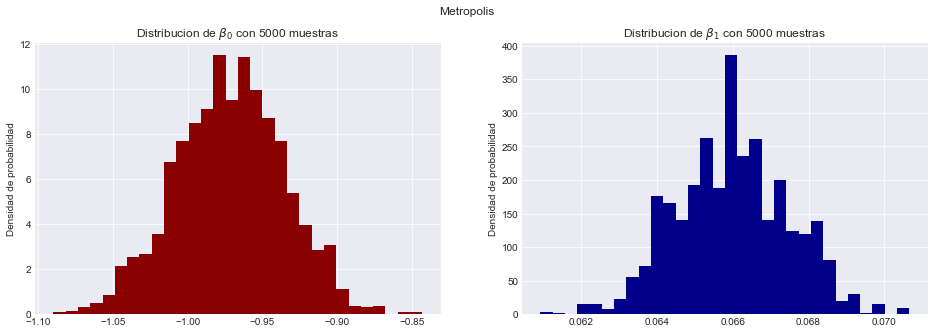

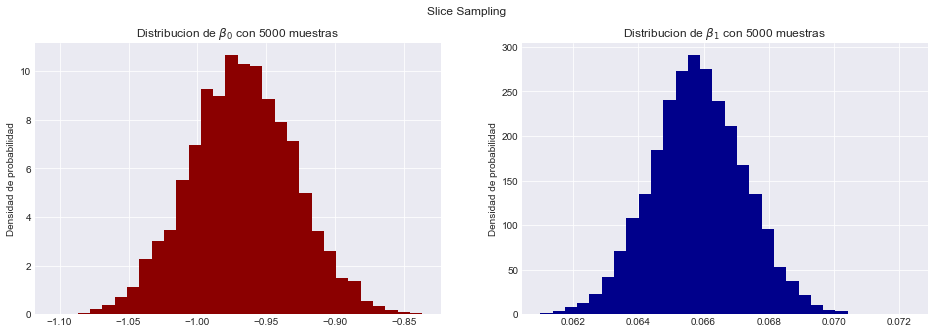

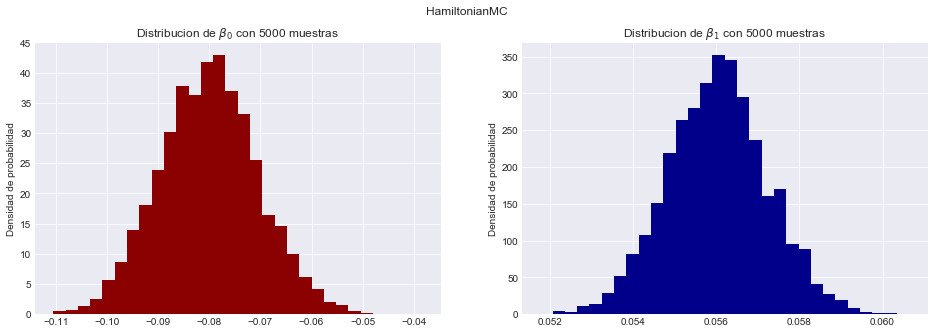

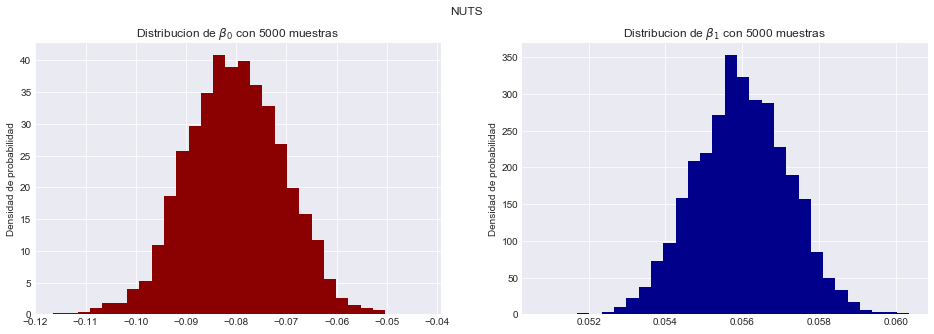

In [38]:
sleep1_met_b = [sleep1_met["beta0"][5000:], sleep1_met["beta1"][5000:]]
sleep1_ss_b = [sleep1_ss["beta0"][5000:], sleep1_ss["beta1"][5000:]]
sleep1_hmc_b = [sleep1_hmc["beta0"][5000:], sleep1_hmc["beta1"][5000:]]
sleep1_nut_b = [sleep1_nut["beta0"][5000:], sleep1_nut["beta1"][5000:]]

plot_hist(sleep1_met_b[0], sleep1_met_b[1], n_samples, "Metropolis")
plot_hist(sleep1_ss_b[0], sleep1_ss_b[1], n_samples, "Slice Sampling")
plot_hist(sleep1_hmc_b[0], sleep1_hmc_b[1], n_samples, "HamiltonianMC")
plot_hist(sleep1_nut_b[0], sleep1_nut_b[1], n_samples, "NUTS")

Las muestras obtenidas con Metropolis Hasting no tiene una forma normal definida como los otros métodos. En el caso de Slice sampling, HamiltonianMC y NUTS los graficos tienen la forma de una distribución normal, para el primer gráfico centrado cerca de -0.095, y oara los dos siguientes centrados cerca de -0.08, para $\beta_0$. Para $\beta_1$ se repite la igualdad entre los primeros dos y los útlimos dos métodos, pero a diferencia de $\beta_0$, están dentro de un mismo rango pero desplazados en 0.01 unidades respecto al centro de los histogramas.

Todas las muestras de $\beta_0$ son menores que 0, lo que para este modelo implicaría que se duerme después de las 10:00 pm, pues si las muestras de $\beta_0$ estuviesen centrado en 0 querría decir que se duerme a las 10:00PM

Todas las muestras de $\beta_1$ son mayores a 0, lo que implicaría una pendiente positiva y por su valor estimado no tan pronunciada.

In [41]:
reg_logistic = lambda x, beta0, beta1 : 1 / (1 + np.exp(-(beta0 + beta1*x)))
sleep1_time_est = np.linspace(sleep1_time.min()- 15, sleep1_time.max() + 15)[:, None]

In [42]:
sleep1_met_means = [sleep1_met_b[0].mean(), sleep1_met_b[1].mean()]
sleep1_ss_means = [sleep1_ss_b[0].mean(), sleep1_ss_b[1].mean()]
sleep1_hmc_means = [sleep1_hmc_b[0].mean(), sleep1_hmc_b[1].mean()]
sleep1_nut_means = [sleep1_nut_b[0].mean(), sleep1_nut_b[1].mean()]

# Probabilidad en cada tiempo dado por las medias de las betas
sleep1_met_est = reg_logistic(sleep1_time_est, sleep1_met_means[0], sleep1_met_means[1])
sleep1_ss_est = reg_logistic(sleep1_time_est, sleep1_ss_means[0], sleep1_ss_means[1])
sleep1_hmc_est = reg_logistic(sleep1_time_est, sleep1_hmc_means[0], sleep1_hmc_means[1])
sleep1_nut_est = reg_logistic(sleep1_time_est, sleep1_nut_means[0], sleep1_nut_means[1])

[-0.971463764880464, 0.06598948542501937] [-0.9675647598041586, 0.06582764404170031] [-0.08005711647639062, 0.056028977005044216] [-0.08023453103124534, 0.055974386636160854]


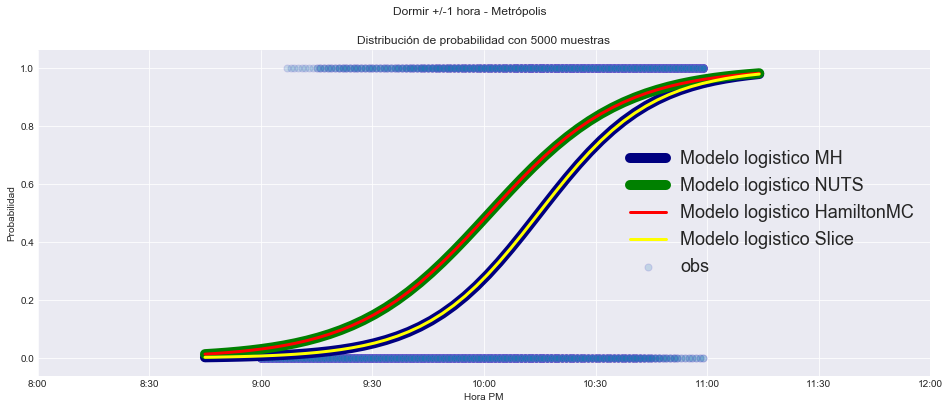

In [58]:
print(sleep1_met_means, sleep1_ss_means, sleep1_hmc_means, sleep1_nut_means)
plot_fit(sleep1_time_est, sleep1_met_est, sleep1_nut_est, sleep1_hmc_est, sleep1_ss_est,
         sleep1_time, sleep1_obs, n_samples, "Dormir +/-1 hora", "PM", sleep_labels)

Dada la igualdad que se visualizó en los histogramas se obtienen medias para $\beta_0$ y $\beta_1$ muy cercanas entre Metropolis y Slice S., y HamiltonianMC y NUTS. A pesar de que NUTS es una variantes de HamiltonianMC no se esperaba que los resultados fuesen tan parecidos. Para los otros dos métodos es algo sorpresivo pues la heurística que hay por detrás cambia.

HamiltonianMC y NUTS van por sobre los otros métodos, haciendo que la transición entre despierto y dormido se acerque a una función lineal en todo el espectro de horas.

## Análisis de convergencia

Luego de generar las muestras hay que corroborar si estás divergen o convergen a un valor. Además, es interesante analizar la velocidad con que cada algortimo se aproxima a su valor de convergencia, y si estos se estancan tempranamente en un óptimo local.

Los primeros gráficos que se mostrarán en el conjunto de gráficos es el traceplot, que grafica las muestras que se obtienen (izquierda) y las muestras que se van obteniendo a lo largo de las iteraciones (izquierda). Esto se hace para beta0 y beta1. Luego viene Forest Plot que da el punto, con una confianza, del rango de valores de las muestras con el intervalo de confianza (izquierda); y a la derecha Rhat es el estadístico de Gelman Rubin. Los útlimos cuatro gráficos son las autocorrelaciones de las muestras obtenidas.

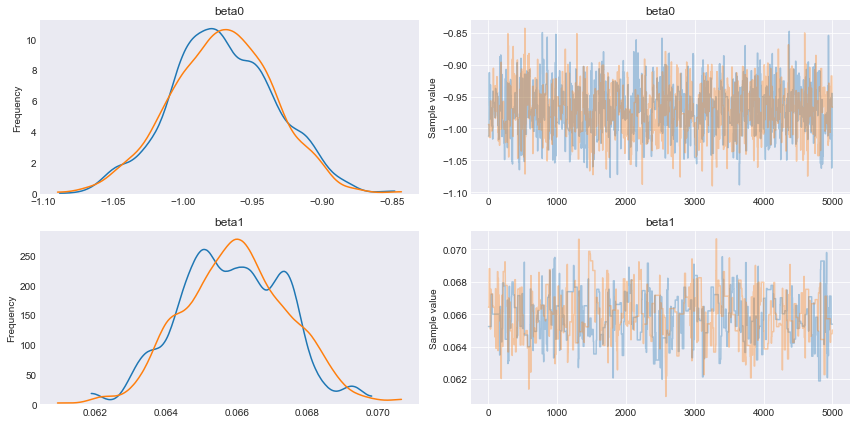

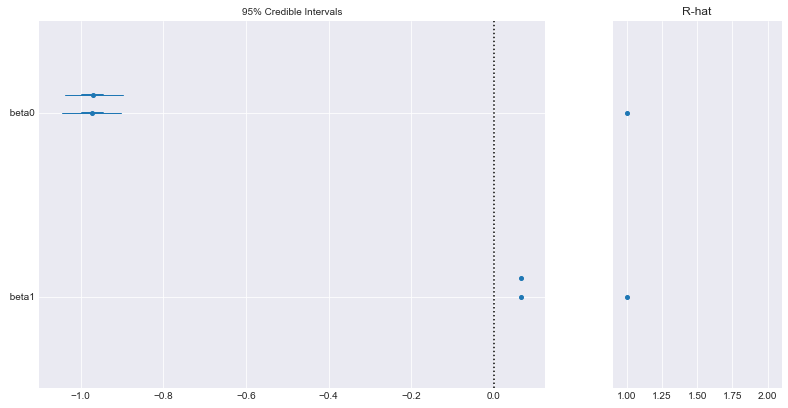

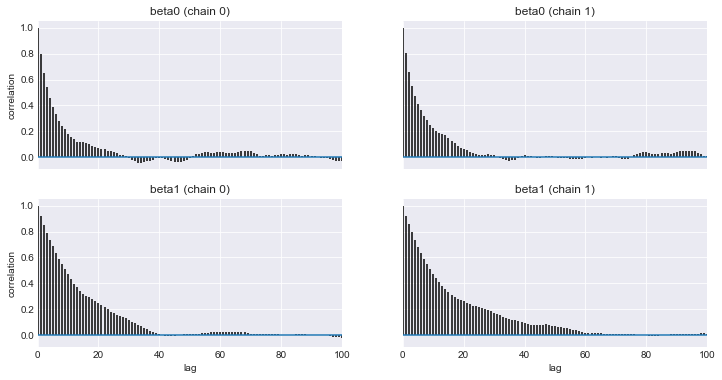

In [60]:
graph_analysis(sleep1_met, "Dormido +/-1 hora Metropolis");

Los gráficos de traceplot de condicen con los histogramas de valores sampleados y lo que interesa acá es que se van sacando muestras al rededor de una media variando en un rando de *Samples value* casi constante.

Para la segunda tanta de gráficos se visualiza que beta0 tiene un rango de valores mayores a los de beta1, siendo el rango de valores de este último imperciptible (porque los valores min y max tienen una distancia de 0.01 aproximado. El gráfico de Rhat indica que se llega a una convergencia para ambas betas.

En relación a los gráficos de autocorrelación, se visualiza como al comienzo del muestreo existe una alta dependencia entre los datos generados pero esta va disminuyendo a lo largo del tiempo. Para beta0 (cadena 1 y 2) y beta1 (cadena 1) a pesar de que llega a valores muy cercanos a cero en un momento se produce un aumento de dependencia entre los datos. Por lo tanto, siempre existe un grado de dependencia entre las muestras.

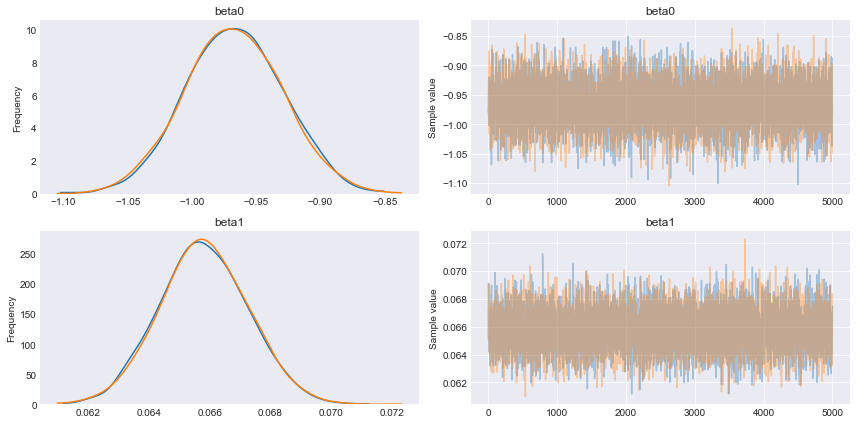

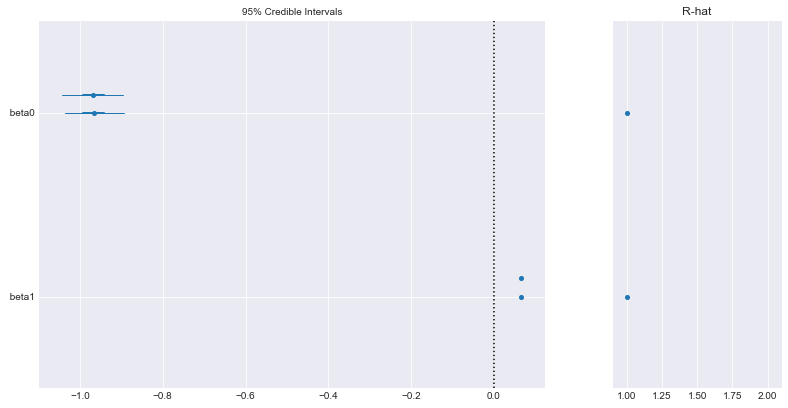

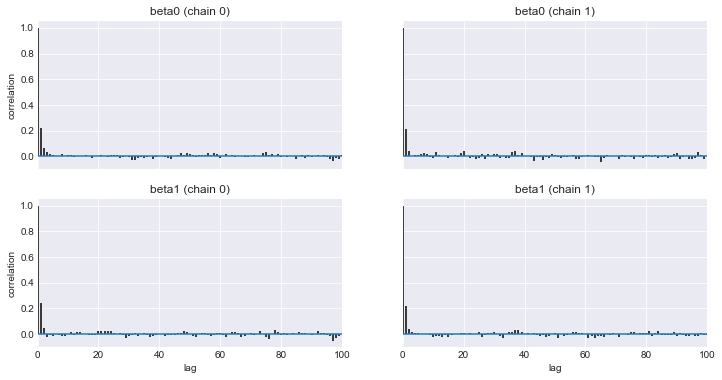

In [61]:
graph_analysis(sleep1_ss, "Dormido +/-1 hora Slice Sampling");

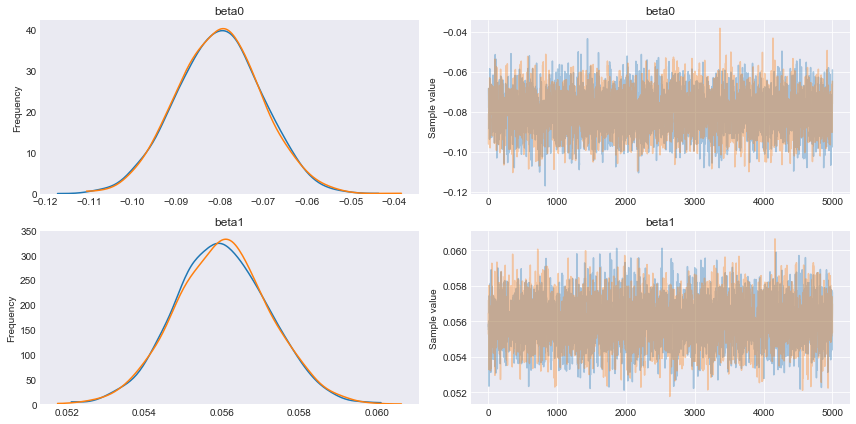

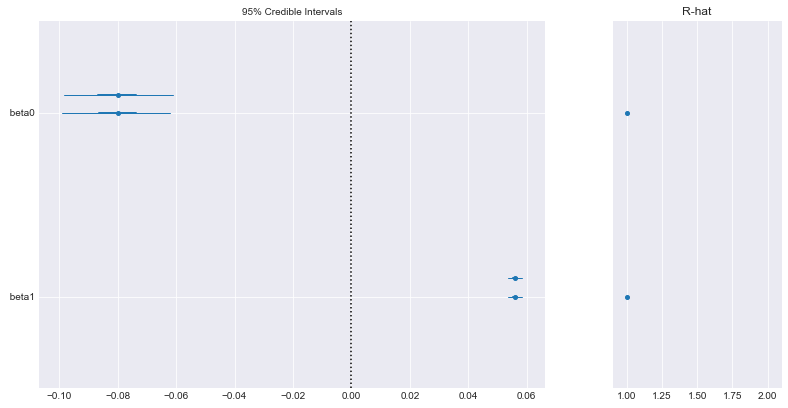

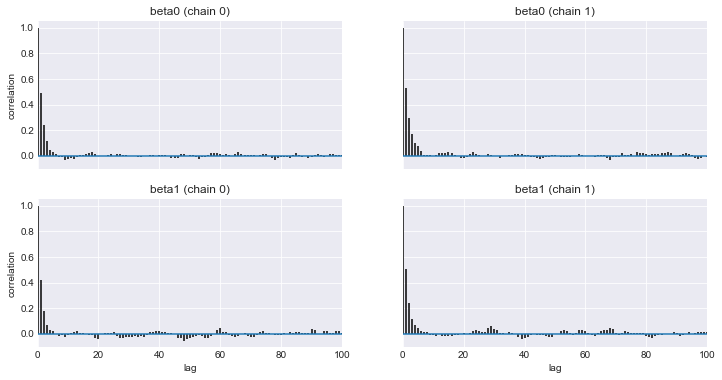

In [62]:
graph_analysis(sleep1_hmc, "Dormido +/-1 hora HamiltonianMC");

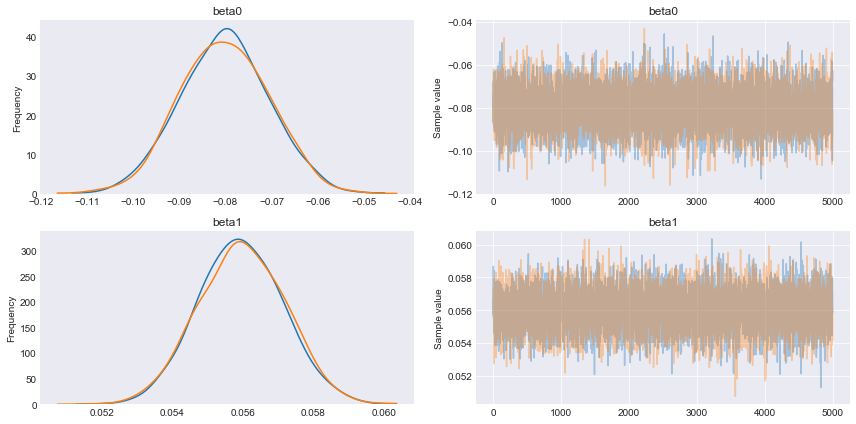

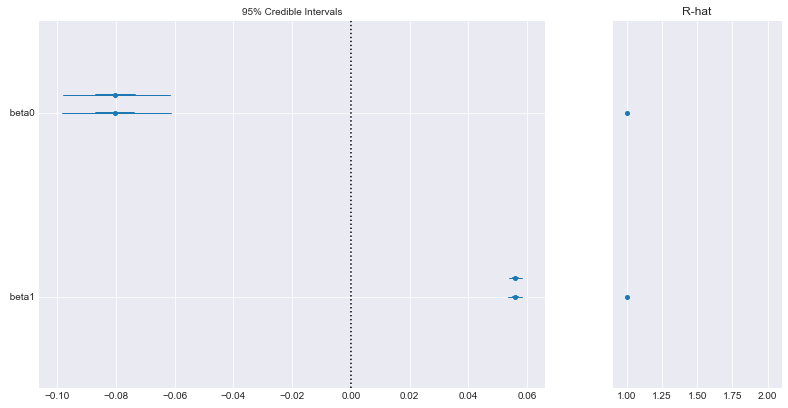

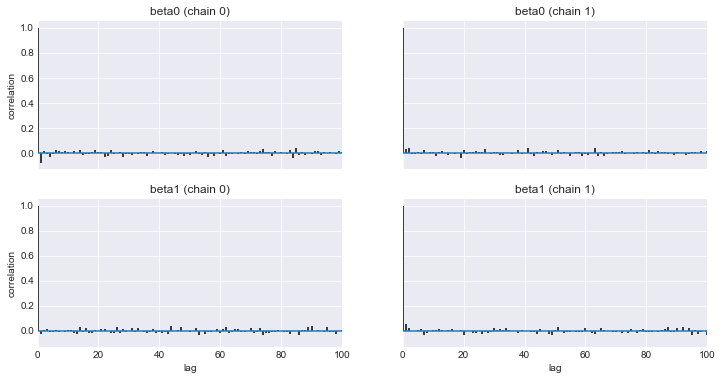

In [63]:
graph_analysis(sleep1_nut, "Dormido +/-1 hora NUTS");

### Geweke

1.98 desviaciones estadar. seugn z score los estadisticos convergen


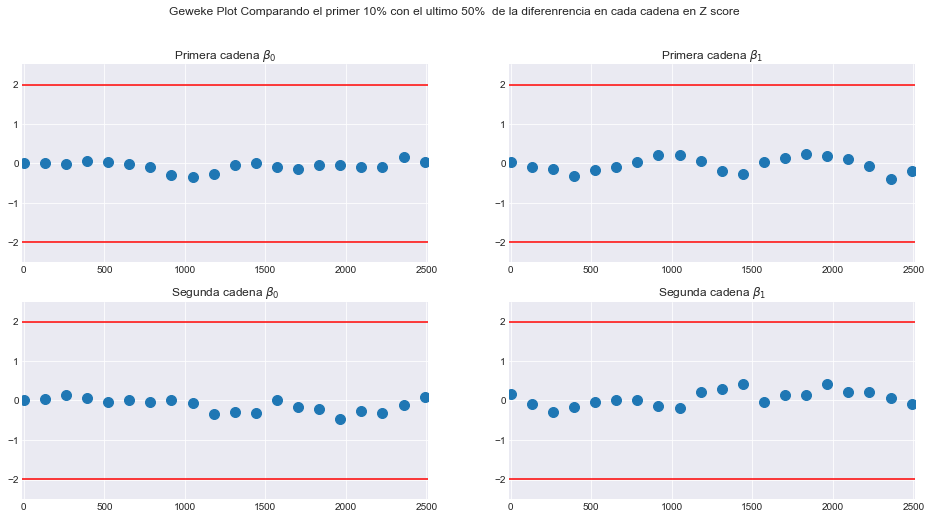

In [64]:
geweke(sleep1_met)

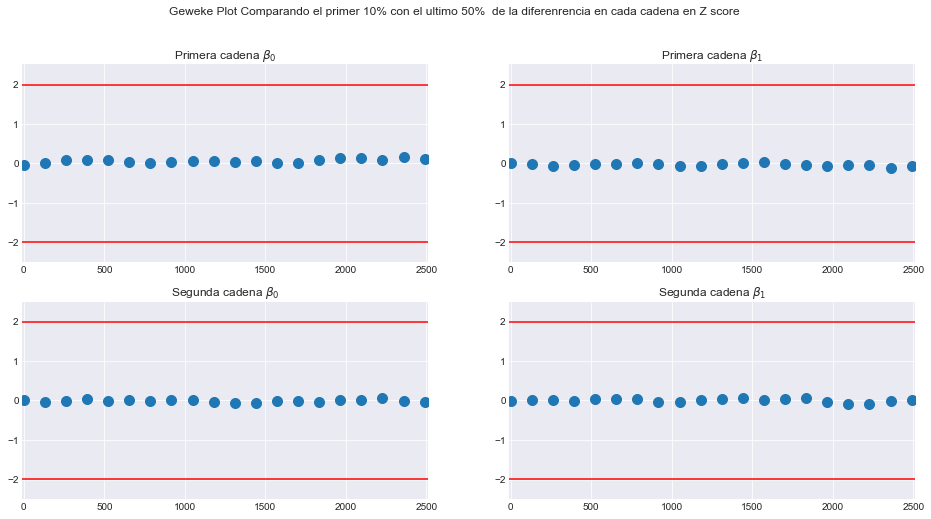

In [65]:
geweke(sleep1_ss)

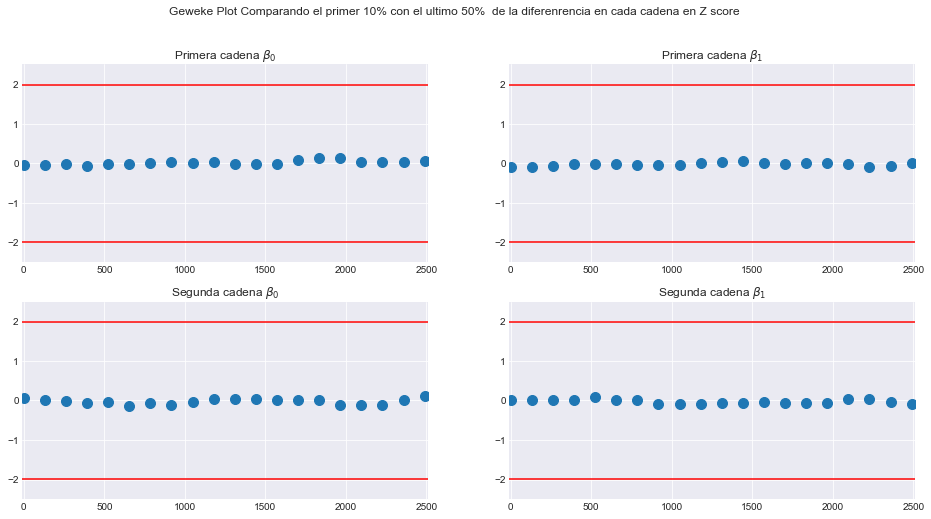

In [66]:
geweke(sleep1_hmc)

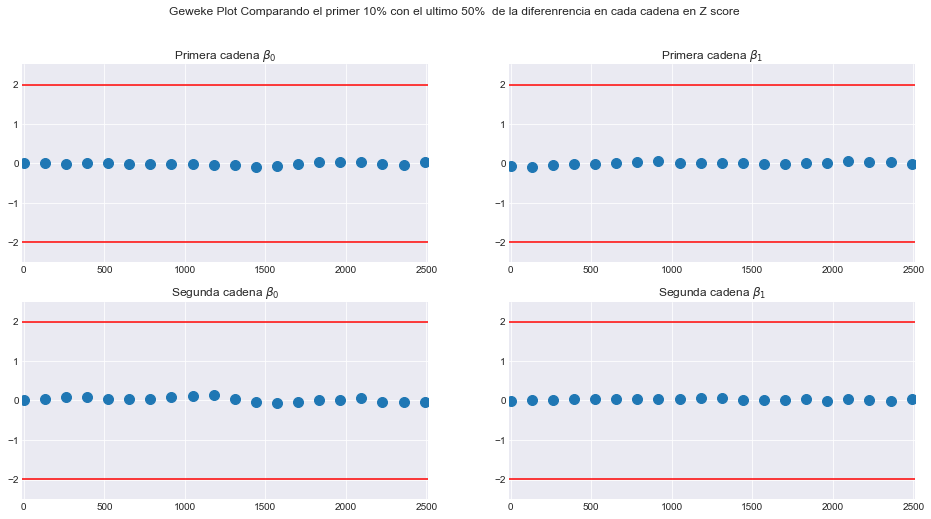

In [67]:
geweke(sleep1_nut)

### Gelman Rubin

se conprueba lo de arriba pq los betas son cercanos a uno

In [77]:
gelman_rubin(sleep1_met)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  0.9999666538081203
	 El parámetro beta1 ha convergido
	 	 beta1:  1.0018886730782677


In [78]:
gelman_rubin(sleep1_ss)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  0.9999917451355078
	 El parámetro beta1 ha convergido
	 	 beta1:  1.000005547593452


In [79]:
gelman_rubin(sleep1_hmc)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  0.9999083074966358
	 El parámetro beta1 ha convergido
	 	 beta1:  0.9999871270651539


In [80]:
gelman_rubin(sleep1_nut)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  0.9999032739710236
	 El parámetro beta1 ha convergido
	 	 beta1:  1.0000600366952996


### Running Means

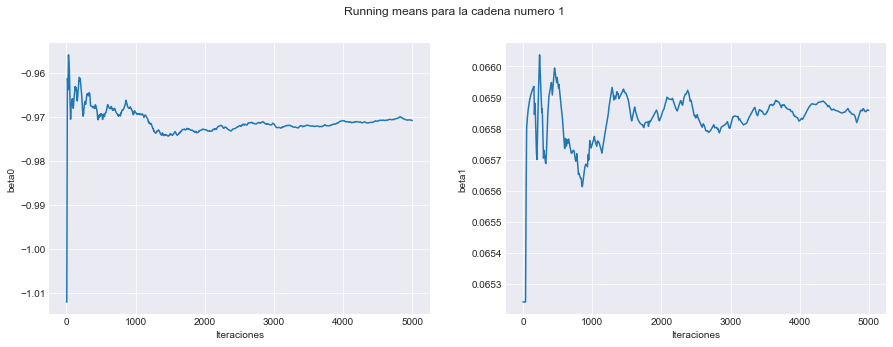

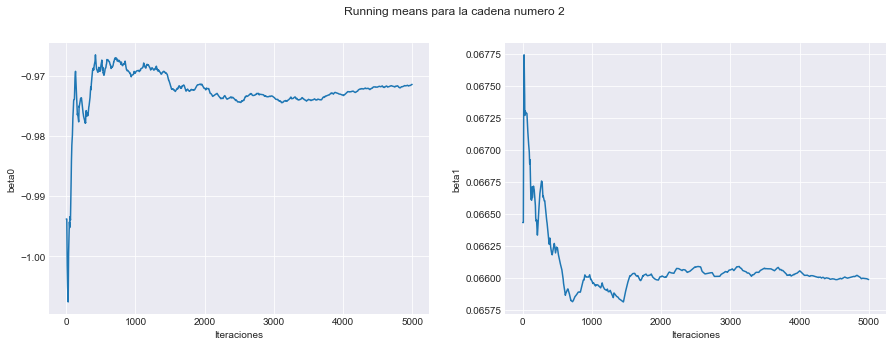

In [72]:
running_means(sleep1_met)

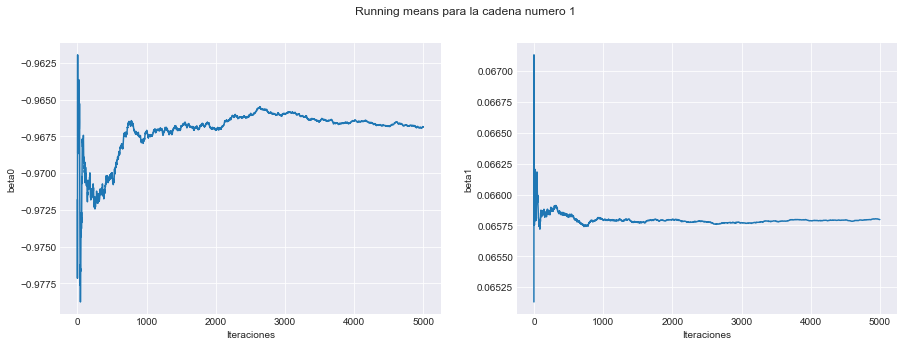

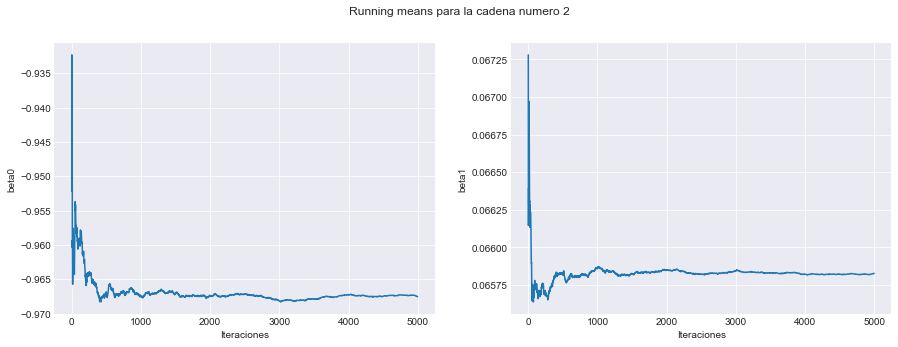

In [73]:
running_means(sleep1_ss)

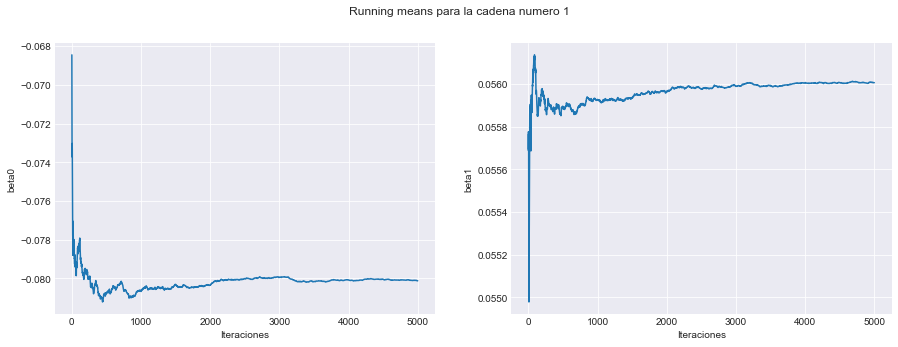

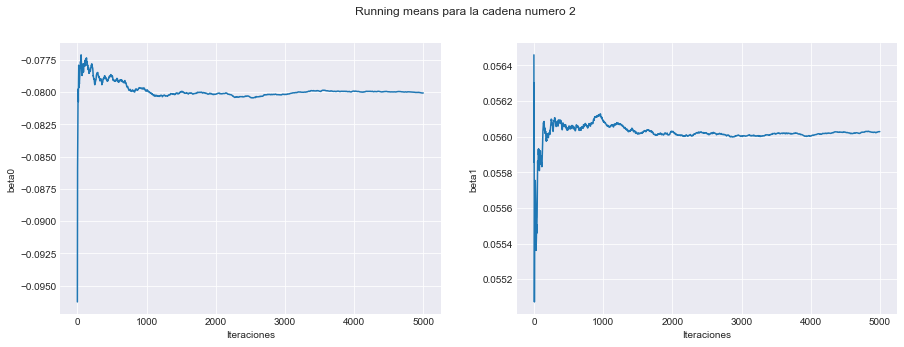

In [74]:
running_means(sleep1_hmc)

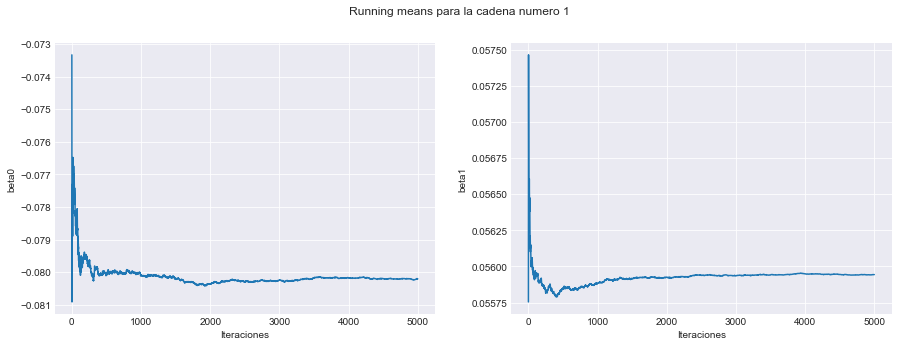

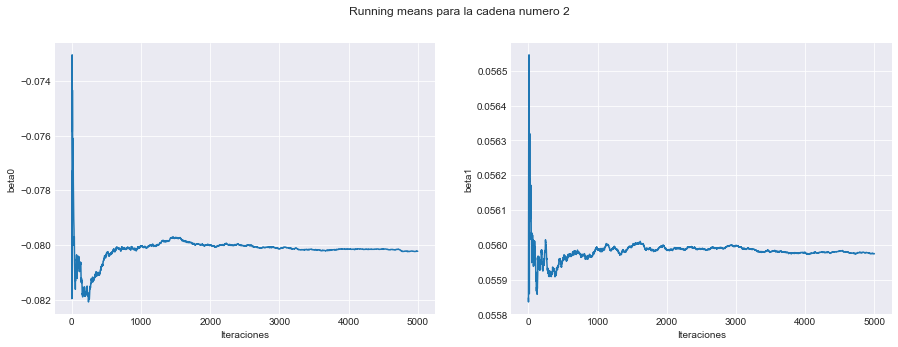

In [75]:
running_means(sleep1_nut)

In [84]:
print('La probabilidad de estar dormido supera el 50% a las:')
print('Metropolis\t 10:{} PM.'.format(int(sleep1_time_est[np.where(sleep1_met_est > 0.5)[0][0]][0])))
print('Slice Sam.\t 10:{} PM.'.format(int(sleep1_time_est[np.where(sleep1_ss_est > 0.5)[0][0]][0])))
print('HMC       \t 10:{} PM.'.format(int(sleep1_time_est[np.where(sleep1_hmc_est > 0.5)[0][0]][0])))
print('NUTS      \t 10:{} PM.'.format(int(sleep1_time_est[np.where(sleep1_nut_est > 0.5)[0][0]][0])))

La probabilidad de estar dormido supera el 50% a las:
Metropolis	 10:16 PM.
Slice Sam.	 10:16 PM.
HMC       	 10:4 PM.
NUTS      	 10:4 PM.


In [92]:
def probability_examples(means, method):
    print("Usando %s Probabilidad de estar dormido a las:" % method)
    print('10:00 PM : {:.2f}%.'.format(100 * reg_logistic(0, means[0], means[1])))
    print(' 9:30 PM : {:.2f}%.'.format(100 * reg_logistic(-30, means[0], means[1])))
    print('10:30 PM : {:.2f}%.'.format(100 * reg_logistic(30, means[0], means[1])))

probability_examples(sleep1_met_means, "Metropolis")
probability_examples(sleep1_ss_means, "Slice Sampling")
probability_examples(sleep1_hmc_means, "HMC")
probability_examples(sleep1_nut_means, "NUTS")

Usando Metropolis Probabilidad de estar dormido a las:
10:00 PM : 27.46%.
 9:30 PM : 4.97%.
10:30 PM : 73.27%.
Usando Slice Sampling Probabilidad de estar dormido a las:
10:00 PM : 27.54%.
 9:30 PM : 5.01%.
10:30 PM : 73.25%.
Usando HMC Probabilidad de estar dormido a las:
10:00 PM : 48.00%.
 9:30 PM : 14.67%.
10:30 PM : 83.21%.
Usando NUTS Probabilidad de estar dormido a las:
10:00 PM : 48.00%.
 9:30 PM : 14.69%.
10:30 PM : 83.19%.


# Modelo Dormir +/-2 hora

#### Histograma de los parámetros estimados $\beta_0$ y $\beta_1$

Distribución posterior de los parámetros $\beta_0$ y $\beta_1$. Se graficarán los histogramas de los valores sampleados por cada técnica.

In [ ]:
sleep2_met_b = [sleep2_met["beta0"][5000:], sleep2_met["beta1"][5000:]]
sleep2_ss_b = [sleep2_ss["beta0"][5000:], sleep2_ss["beta1"][5000:]]
sleep2_hmc_b = [sleep2_hmc["beta0"][5000:], sleep2_hmc["beta1"][5000:]]
sleep2_nut_b = [sleep2_nut["beta0"][5000:], sleep2_nut["beta1"][5000:]]

plot_hist(sleep2_met_b[0], sleep2_met_b[1], n_samples, "Metropolis")
plot_hist(sleep2_ss_b[0], sleep2_ss_b[1], n_samples, "Slice Sampling")
plot_hist(sleep2_hmc_b[0], sleep2_hmc_b[1], n_samples, "HamiltonianMC")
plot_hist(sleep2_nut_b[0], sleep2_nut_b[1], n_samples, "NUTS")

In [ ]:
sleep2_time_est = np.linspace(sleep2_time.min()- 15, sleep2_time.max() + 15)[:, None]

sleep2_met_means = [sleep2_met_b[0].mean(), sleep2_met_b[1].mean()]
sleep2_ss_means = [sleep2_ss_b[0].mean(), sleep2_ss_b[1].mean()]
sleep2_hmc_means = [sleep2_hmc_b[0].mean(), sleep2_hmc_b[1].mean()]
sleep2_nut_means = [sleep2_nut_b[0].mean(), sleep2_nut_b[1].mean()]

# Probabilidad en cada tiempo dado por las medias de las betas
sleep2_met_est = reg_logistic(sleep2_time_est, sleep2_met_means[0], sleep2_met_means[1])
sleep2_ss_est = reg_logistic(sleep2_time_est, sleep2_ss_means[0], sleep2_ss_means[1])
sleep2_hmc_est = reg_logistic(sleep2_time_est, sleep2_hmc_means[0], sleep2_hmc_means[1])
sleep2_nut_est = reg_logistic(sleep2_time_est, sleep2_nut_means[0], sleep2_nut_means[1])

In [ ]:
print(sleep2_met_means, sleep2_ss_means, sleep2_hmc_means, sleep2_nut_means)
plot_fit(sleep2_time_est, sleep2_met_est, sleep2_nut_est, sleep2_hmc_est, sleep2_ss_est,
         sleep2_time, sleep2_obs, n_samples, "Dormir +/-2 hora", "PM", sleep_labels)

## Análisis de convergencia

In [ ]:
graph_analysis(sleep2_met, "Dormido +/-2 hora Metropolis");

In [ ]:
graph_analysis(sleep2_ss, "Dormido +/-2 hora Metropolis");

In [ ]:
graph_analysis(sleep2_hmc, "Dormido +/-2 hora Metropolis");

In [ ]:
graph_analysis(sleep2_nut, "Dormido +/-2 hora Metropolis");

### Geweke

1.98 desviaciones estadar. seugn z score los estadisticos convergen


In [ ]:
geweke(sleep2_met)

In [ ]:
geweke(sleep2_ss)

In [ ]:
geweke(sleep2_hmc)

In [ ]:
geweke(sleep2_nut)

### Gelman Rubin

se conprueba lo de arriba pq los betas son cercanos a uno

In [ ]:
gelman_rubin(sleep2_met)

In [ ]:
gelman_rubin(sleep2_ss)

In [ ]:
gelman_rubin(sleep2_hmc)

In [ ]:
gelman_rubin(sleep2_nut)

### Running means

In [ ]:
running_means(sleep2_met)

In [ ]:
running_means(sleep2_ss)

In [ ]:
running_means(sleep2_hmc)

In [ ]:
running_means(sleep2_nut)

In [ ]:
print('La probabilidad de estar dormido supera el 50% a las:')
print('Metropolis\t 10:{} PM.'.format(int(sleep2_time_est[np.where(sleep2_met_est > 0.5)[0][0]][0])))
print('Slice Sam.\t 10:{} PM.'.format(int(sleep2_time_est[np.where(sleep2_ss_est > 0.5)[0][0]][0])))
print('HMC       \t 10:{} PM.'.format(int(sleep2_time_est[np.where(sleep2_hmc_est > 0.5)[0][0]][0])))
print('NUTS      \t 10:{} PM.'.format(int(sleep2_time_est[np.where(sleep2_nut_est > 0.5)[0][0]][0])))

In [ ]:
probability_examples(sleep2_met_means, "Metropolis")
probability_examples(sleep2_ss_means, "Slice Sampling")
probability_examples(sleep2_hmc_means, "HMC")
probability_examples(sleep2_nut_means, "NUTS")

# Modelo Despertar +/-1 hora

# Modelo Despertar +/-2 hora